In [1]:
# 1. Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime

%matplotlib inline

In [3]:
# 2. Load Data

transactions_df = pd.read_csv('TRANSACTION_TAKEHOME.csv')
users_df = pd.read_csv('USER_TAKEHOME.csv')
products_df = pd.read_csv('PRODUCTS_TAKEHOME.csv')

In [4]:
# 3. Explore Data Quality

def check_missing_values(df, name):
    print(f"\n{name} - Missing Values (%):")
    print((df.isnull().sum() / len(df) * 100).round(2))

# Check missing values
check_missing_values(transactions_df, 'Transactions')
check_missing_values(users_df, 'Users')
check_missing_values(products_df, 'Products')

# Data types and basic info
print("\nTransactions Info:")
transactions_df.info()

print("\nUsers Info:")
users_df.info()

print("\nProducts Info:")
products_df.info()


Transactions - Missing Values (%):
RECEIPT_ID         0.00
PURCHASE_DATE      0.00
SCAN_DATE          0.00
STORE_NAME         0.00
USER_ID            0.00
BARCODE           11.52
FINAL_QUANTITY     0.00
FINAL_SALE         0.00
dtype: float64

Users - Missing Values (%):
ID               0.00
CREATED_DATE     0.00
BIRTH_DATE       3.68
STATE            4.81
LANGUAGE        30.51
GENDER           5.89
dtype: float64

Products - Missing Values (%):
CATEGORY_1       0.01
CATEGORY_2       0.17
CATEGORY_3       7.16
CATEGORY_4      92.02
MANUFACTURER    26.78
BRAND           26.78
BARCODE          0.48
dtype: float64

Transactions Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RECEIPT_ID      50000 non-null  object 
 1   PURCHASE_DATE   50000 non-null  object 
 2   SCAN_DATE       50000 non-null  object 
 3   STORE_NAME      50000 

In [7]:
# 4. Visualize Missing Data (Tabular Format)


# Function to create a DataFrame with missing value percentages
def get_missing_data_table(df, dataset_name):
    missing_data = pd.DataFrame({
        'Column': df.columns,
        'Missing_Values': df.isnull().sum(),
        'Total_Values': len(df),
        'Missing_Percentage (%)': (df.isnull().sum() / len(df) * 100).round(2)
    })
    missing_data['Dataset'] = dataset_name
    return missing_data.sort_values(by='Missing_Percentage (%)', ascending=False)

# Generate missing data tables for all datasets
transactions_missing_df = get_missing_data_table(transactions_df, "Transactions")
users_missing_df = get_missing_data_table(users_df, "Users")
products_missing_df = get_missing_data_table(products_df, "Products")

# Combine all into one DataFrame for comparison
combined_missing_df = pd.concat([transactions_missing_df, users_missing_df, products_missing_df], ignore_index=True)

# Display the combined DataFrame
combined_missing_df.reset_index(drop=True, inplace=True)
combined_missing_df

,Column,Missing_Values,Total_Values,Missing_Percentage (%),Dataset
0,BARCODE,5762,50000,11.52,Transactions
1,RECEIPT_ID,0,50000,0.00,Transactions
2,PURCHASE_DATE,0,50000,0.00,Transactions
3,SCAN_DATE,0,50000,0.00,Transactions
4,STORE_NAME,0,50000,0.00,Transactions
5,USER_ID,0,50000,0.00,Transactions
6,FINAL_QUANTITY,0,50000,0.00,Transactions
7,FINAL_SALE,0,50000,0.00,Transactions
8,LANGUAGE,30508,100000,30.51,Users
9,GENDER,5892,100000,5.89,Users


In [13]:
# 5. Data Cleaning

# Convert date columns to datetime (removing timezone information)
users_df['BIRTH_DATE'] = pd.to_datetime(users_df['BIRTH_DATE'], errors='coerce').dt.tz_localize(None)
users_df['CREATED_DATE'] = pd.to_datetime(users_df['CREATED_DATE'], errors='coerce').dt.tz_localize(None)
transactions_df['PURCHASE_DATE'] = pd.to_datetime(transactions_df['PURCHASE_DATE'], errors='coerce').dt.tz_localize(None)
transactions_df['SCAN_DATE'] = pd.to_datetime(transactions_df['SCAN_DATE'], errors='coerce').dt.tz_localize(None)

# Convert 'FINAL_QUANTITY' & 'FINAL_SALE' to numeric
transactions_df['FINAL_QUANTITY'] = pd.to_numeric(transactions_df['FINAL_QUANTITY'].replace('zero', 0), errors='coerce')
transactions_df['FINAL_SALE'] = pd.to_numeric(transactions_df['FINAL_SALE'], errors='coerce')

# Calculate age of users
current_date = pd.to_datetime("today").tz_localize(None)
users_df['AGE'] = ((current_date - users_df['BIRTH_DATE']).dt.days // 365).fillna(0).astype(int)

# Calculate account age in months
users_df['ACCOUNT_AGE_MONTHS'] = ((current_date - users_df['CREATED_DATE']).dt.days // 30).fillna(0).astype(int)

# Display cleaned DataFrame samples
users_df.head(), transactions_df.head()


(                         ID        CREATED_DATE          BIRTH_DATE STATE  \
 0  5ef3b4f17053ab141787697d 2020-06-24 20:17:54 2000-08-11 00:00:00    CA   
 1  5ff220d383fcfc12622b96bc 2021-01-03 19:53:55 2001-09-24 04:00:00    PA   
 2  6477950aa55bb77a0e27ee10 2023-05-31 18:42:18 1994-10-28 00:00:00    FL   
 3  658a306e99b40f103b63ccf8 2023-12-26 01:46:22                 NaT    NC   
 4  653cf5d6a225ea102b7ecdc2 2023-10-28 11:51:50 1972-03-19 00:00:00    PA   
 
   LANGUAGE  GENDER  AGE  ACCOUNT_AGE_MONTHS  
 0   es-419  female   24                  56  
 1       en  female   23                  50  
 2   es-419  female   30                  21  
 3       en     NaN    0                  14  
 4       en  female   52                  16  ,
                              RECEIPT_ID PURCHASE_DATE               SCAN_DATE  \
 0  0000d256-4041-4a3e-adc4-5623fb6e0c99    2024-08-21 2024-08-21 14:19:06.539   
 1  0001455d-7a92-4a7b-a1d2-c747af1c8fd3    2024-07-20 2024-07-20 09:50:24.206   
 

In [14]:
# 6. Create In-Memory SQL Database

conn = sqlite3.connect(':memory:')

# Load DataFrames into SQLite tables
users_df.to_sql('users', conn, index=False, if_exists='replace')
transactions_df.to_sql('transactions', conn, index=False, if_exists='replace')
products_df.to_sql('products', conn, index=False, if_exists='replace')

845552

In [18]:
# 7. SQL Queries

# Query 1: Top 5 brands by receipts scanned among users 21 and over
query1 = """
SELECT p.BRAND, COUNT(DISTINCT t.RECEIPT_ID) AS receipts_scanned
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE u.AGE >= 21
GROUP BY p.BRAND
ORDER BY receipts_scanned DESC
LIMIT 5;
"""

# Query 2: Top 5 brands by sales among users with accounts older than 6 months
query2 = """
SELECT p.BRAND, SUM(t.FINAL_SALE) AS total_sales
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE u.ACCOUNT_AGE_MONTHS >= 6
GROUP BY p.BRAND
ORDER BY total_sales DESC
LIMIT 5;
"""

# Query 3 Top 5 Most Purchased Products by Quantity
query3 = """
SELECT p.BRAND, SUM(t.FINAL_QUANTITY) AS total_quantity
FROM transactions t
JOIN products p ON t.BARCODE = p.BARCODE
GROUP BY p.BRAND
ORDER BY total_quantity DESC
LIMIT 5;
"""

top_brands_receipts = pd.read_sql_query(query1, conn)
top_brands_sales = pd.read_sql_query(query2, conn)
top_products_quantity = pd.read_sql_query(query3, conn)

C:\Users\HAKIM POCKETWALLA\AppData\Local\Temp\ipykernel_36676\3340527187.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='receipts_scanned', y='BRAND', data=top_brands_receipts, palette='coolwarm')


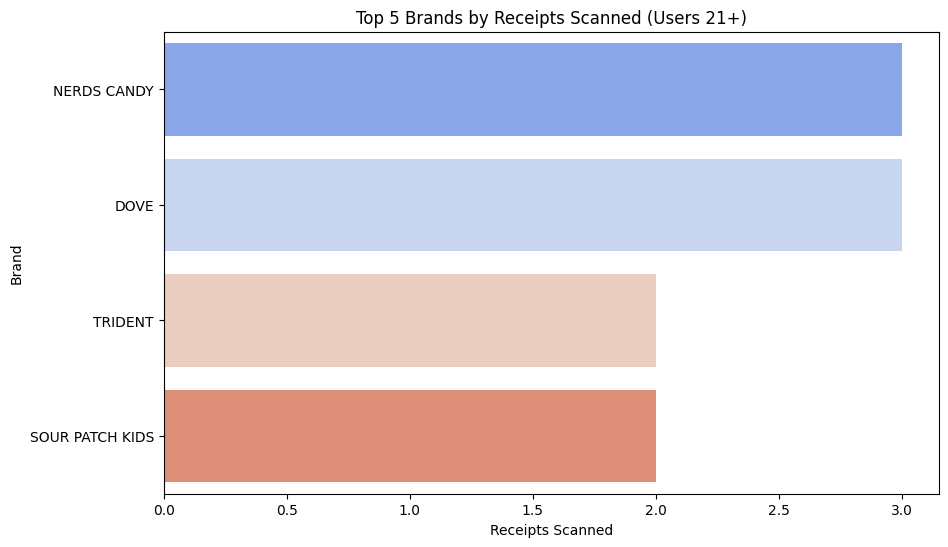

C:\Users\HAKIM POCKETWALLA\AppData\Local\Temp\ipykernel_36676\3340527187.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_sales', y='BRAND', data=top_brands_sales, palette='viridis')


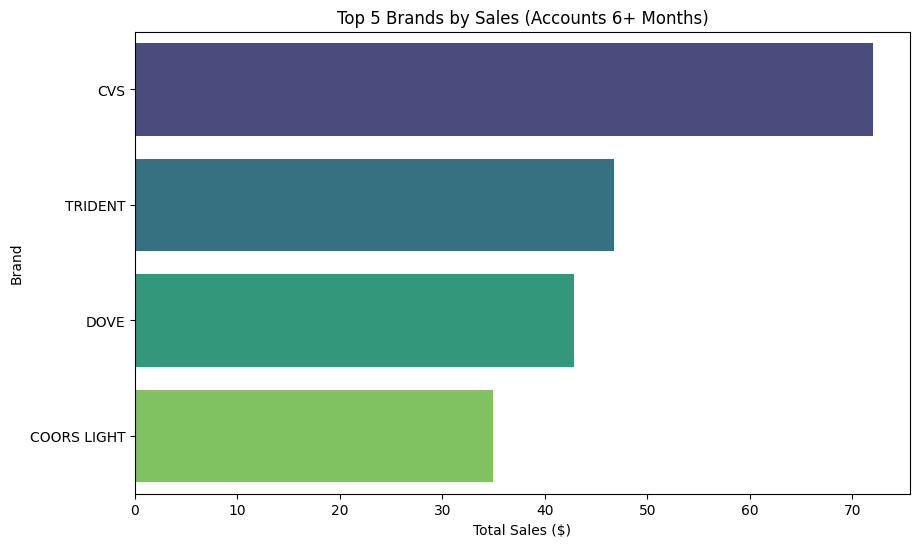

C:\Users\HAKIM POCKETWALLA\AppData\Local\Temp\ipykernel_36676\3340527187.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_quantity', y='BRAND', data=top_products_quantity, palette='Purples_r')


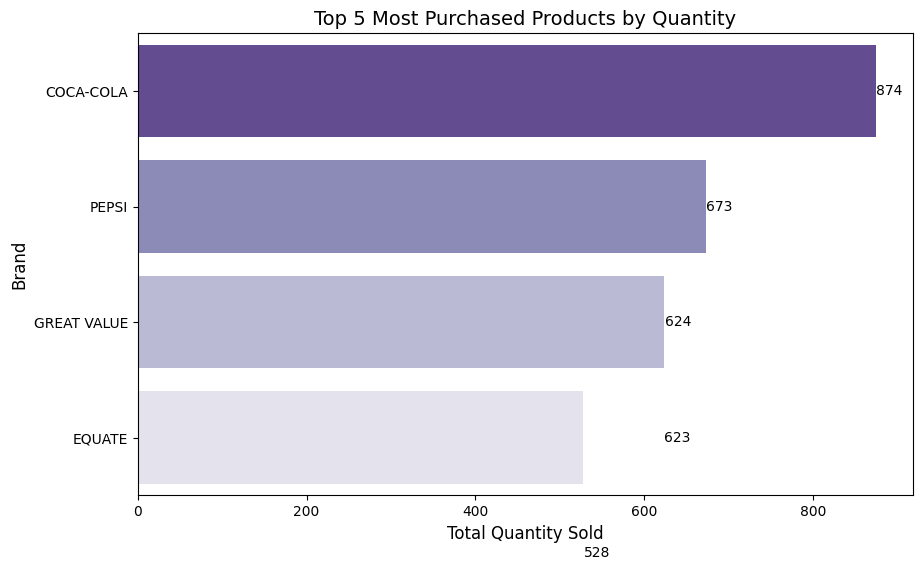

In [20]:
# 8. Visualize Query Results

# Top 5 brands by receipts scanned
plt.figure(figsize=(10,6))
sns.barplot(x='receipts_scanned', y='BRAND', data=top_brands_receipts, palette='coolwarm')
plt.title('Top 5 Brands by Receipts Scanned (Users 21+)')
plt.xlabel('Receipts Scanned')
plt.ylabel('Brand')
plt.show()

# Top 5 brands by sales
plt.figure(figsize=(10,6))
sns.barplot(x='total_sales', y='BRAND', data=top_brands_sales, palette='viridis')
plt.title('Top 5 Brands by Sales (Accounts 6+ Months)')
plt.xlabel('Total Sales ($)')
plt.ylabel('Brand')
plt.show()

# Top 5 Most Purchased Products by Quantity
plt.figure(figsize=(10, 6))
sns.barplot(x='total_quantity', y='BRAND', data=top_products_quantity, palette='Purples_r')

for index, value in enumerate(top_products_quantity['total_quantity']):
    plt.text(value + 0.1, index, f"{int(value)}", va='center', fontsize=10)

plt.title('Top 5 Most Purchased Products by Quantity', fontsize=14)
plt.xlabel('Total Quantity Sold', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.show()

In [21]:
# 9. Analysis Summary

print("""
**Data Analysis Summary**

**Data Quality Issues:**
- Transactions contain ~11.5% missing `BARCODE` values and inconsistent quantity formats.
- Users data has ~30% missing `LANGUAGE` fields and ~4% missing `STATE`.
- Products have sparse `CATEGORY_4` information and ~27% missing `BRAND`.
""")


**Data Analysis Summary**

**Data Quality Issues:**
- Transactions contain ~11.5% missing `BARCODE` values and inconsistent quantity formats.
- Users data has ~30% missing `LANGUAGE` fields and ~4% missing `STATE`.
- Products have sparse `CATEGORY_4` information and ~27% missing `BRAND`.

